In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
from langchain_google_vertexai import ChatVertexAI
MODEL_ID="gemini-1.5-flash-001"
PROJECT_ID="genai-exchange-hackathon"
REGION="asia-south1"

llm2 = ChatVertexAI(model_name=MODEL_ID)

In [4]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="llama-3.2-90b-text-preview")

In [5]:
import os
import vertexai
from langchain_google_vertexai import VertexAIEmbeddings
vertexai.init(
        project=os.environ.get("VERTEX_PROJECT_ID"),
        location=os.environ.get("VERTEX_PROJECT_LOCATION")
        )
embeddings = VertexAIEmbeddings(model_name="text-embedding-004", location=REGION, project=PROJECT_ID)

In [6]:
import os
from langchain_qdrant import QdrantVectorStore

def get_vector_store():
    QDRANT_URL=os.environ.get("QDRANT_URL")
    QDRANT_API_KEY=os.environ.get("QDRANT_API_KEY")
    vectorstore = QdrantVectorStore.from_existing_collection(
        collection_name="dsa_notes",
        embedding=embeddings,
        url=QDRANT_URL,
        api_key=QDRANT_API_KEY,
    )
    return vectorstore

vectorstore = get_vector_store()

In [7]:
import datasets
from langchain_core.documents import Document
ds = datasets.load_from_disk(os.path.join("usaco_datasets", "usaco_v3_sampled_with_tests"))




input_states = [
    {
        "name": row["name"],
        "problems": [("question", row["description"])] + [("solution", row["solution"])],
        "test_cases": row["test_cases"],
        "runtime_limit": row["runtime_limit"],
        "problem_level": row["problem_level"],
    }
    for row in ds
]

documents = [
    Document(
        page_content=str(row["problems"]),
        metadata={"runtime_limit": row["runtime_limit"], "problem_level": row["problem_level"]}
        ) 
    for row in input_states
]


In [9]:
len(input_states)

30

In [8]:
# Print the first row of input_states to see the structure
# print("First row of input_states:")
print(input_states[0]["problems"])


[('question', '\nFarmer John has $N$ ($1 \\leq N \\leq 2 \\cdot 10^5$) farms, numbered from $1$ to\n$N$. It is known that FJ closes farm $i$ at time $c_i$. Bessie wakes up at time\n$S$, and wants to maximize the productivity of her day by visiting as many farms\nas possible before they close. She plans to visit farm $i$ on time $t_i + S$.\nBessie must arrive at a farm strictly before Farmer John closes it to actually visit it.\n\nBessie has $Q$ $(1 \\leq Q \\leq 2 \\cdot 10^5)$ queries. For each query, she gives\nyou two integers $S$ and $V$. For each query, output whether Bessie can visit at\nleast $V$ farms if she wakes up at time $S$.\n\nINPUT FORMAT (input arrives from the terminal / stdin):\nThe first line consists of $N$ and $Q$.\n\nThe second line consists of $c_1, c_2, c_3 \\dots c_N$ ($1 \\leq c_i \\leq 10^6$).\n\nThe third line consists of $t_1, t_2, t_3 \\dots t_N$ ($1 \\leq t_i \\leq 10^6$).\n\nThe next $Q$ lines each consist of two integers $V$ ($1 \\leq V \\leq N$) and $S

In [9]:
print(input_states[0]["problem_level"])
print(input_states[0]["name"])

bronze
Maximizing Productivity


In [20]:
from uuid import uuid4

uuids = [str(uuid4()) for _ in range(len(documents))]
vectorstore.add_documents(documents=documents, ids=uuids)


['768a4e07-12ee-4b64-9f61-7737ffa3d5c0',
 '69c79a9a-6ab9-4b51-a2f9-1058c5749969',
 '1245a480-9814-4101-bfa2-56023e265245',
 'd34212f7-3255-409e-85bf-0a3fa638585c',
 '0384379c-3f9e-49f8-b5a6-facf419d0b8f',
 '96afb12c-f547-4372-849c-9bc8fe84b0ab',
 '83314dd0-8e5a-4536-852c-cbc55a5a0431',
 '42df10b0-f55b-4823-a0fb-8b2d820d0f80',
 'd5594839-4c9c-4fe6-b264-f84eafc923af',
 'f0e31e80-93a2-44dc-b8d7-18daa9ea7369',
 '12cfc7dc-219b-4326-8468-506078e824ad',
 '6c0b5e6e-a050-449f-81db-26300127d1bc',
 '294511b0-4685-4eec-888b-012b2f4d1863',
 'a000e747-fba6-4e56-890d-4838ea3a24ac',
 '1d3282f8-51c1-4333-9959-7f30fb342367',
 '7cd8b31a-ffab-4721-85e1-2d31103ab364',
 '8addfa88-aa46-43d7-8785-34879b018658',
 '31c6f01c-9f5a-40f4-af9e-23d03ce6d158',
 'f82ea617-c822-4942-88e5-da4206b821e7',
 '219d4e16-f9de-466c-9ecb-e3bc6e9afe98',
 '4dea184a-6383-4f09-8b1f-89edab0be658',
 '6ed9ab88-1cca-4ace-ac67-e9dc3de1950d',
 '8d9cb9cc-f968-44d3-83a2-0ec10b6df132',
 'fd58b349-8a7f-4327-ae3f-2f23588fe60d',
 'e8ecfa5c-52e0-

In [21]:
results = vectorstore.similarity_search(
    "Farmer John has $N$ ($1 \\leq N \\leq 2 \\cdot 10^5$) farms, numbered from $1$ to\n$N$. It is known that FJ closes farm $i$ at time $c_i$. Bessie wakes up at time\n$S$, and wants to maximize the productivity of her day by visiting as many farms\nas possible before they close. She plans to visit", k=2
)
for res in results:
    print(f"* {res.page_content} [{res.metadata}]")

* [('question', '\nFarmer John has $N$ ($1 \\leq N \\leq 2 \\cdot 10^5$) farms, numbered from $1$ to\n$N$. It is known that FJ closes farm $i$ at time $c_i$. Bessie wakes up at time\n$S$, and wants to maximize the productivity of her day by visiting as many farms\nas possible before they close. She plans to visit farm $i$ on time $t_i + S$.\nBessie must arrive at a farm strictly before Farmer John closes it to actually visit it.\n\nBessie has $Q$ $(1 \\leq Q \\leq 2 \\cdot 10^5)$ queries. For each query, she gives\nyou two integers $S$ and $V$. For each query, output whether Bessie can visit at\nleast $V$ farms if she wakes up at time $S$.\n\nINPUT FORMAT (input arrives from the terminal / stdin):\nThe first line consists of $N$ and $Q$.\n\nThe second line consists of $c_1, c_2, c_3 \\dots c_N$ ($1 \\leq c_i \\leq 10^6$).\n\nThe third line consists of $t_1, t_2, t_3 \\dots t_N$ ($1 \\leq t_i \\leq 10^6$).\n\nThe next $Q$ lines each consist of two integers $V$ ($1 \\leq V \\leq N$) and 

In [8]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

In [9]:
from langchain_community.document_loaders import WikipediaLoader

In [10]:
from langgraph.graph import MessagesState
from operator import add
# from langgraph.graph.message import add_messages
from typing import Annotated

class State(MessagesState):
    summary: str
    context: str
    enough_context: bool = False
    safe: bool = True

In [11]:
from langchain_core.messages import SystemMessage, HumanMessage

simple_solver_prompt = """You are helping with solving a student's questions about data structures and algorithms.

These can be questions about definitions, help with debugging code or hard leetcode style problems to solve.

Think carefully before answering any question. Explain your reasoning.

Do not hallucinate. Do not make up facts. If you don't know how to answer a problem, just say so.

Be concise."""

def simple_solver(state: State):
    
    messages = [SystemMessage(content=simple_solver_prompt)]
    
    # get summary if it exists
    summary = state.get("summary", "")
    
    # if there is summary, we add it to prompt
    if summary:
        
        # add summary to system message
        summary_message = f"Summary of conversation earlier: {summary}"
        
        # append summary to any newer message
        messages += [HumanMessage(content=summary_message)]
    
    messages += state["messages"]
    
    response = llm.invoke(messages)
    # NEED TO PREVENT CONTEXT FROM BALLOONING if I change it to list and want to persist that
    return {"context": response.content}

In [12]:


socratic_prompt = """You are a tutor trying to help a student gain a very strong understanding of a concept/problem. 

You are helping them with a problem and want to help them understand the concepts by figuring out the solution themselves with only nudges in the right direction.

You have the solution above but the student has never seen it.

If the student wants to learn about a new concept: use the solution to provide the necessary context. Then, based on that ask the student a question that requires them to apply the concept in code to help enhance their understanding.

If the question is a problem to solve: based on the solution to the question, use the socratic method to guide the student towards the answer.

Provide hints or prompt the student to think of the next step. If the student seems to be really stuggling with a concept, provide a larger hint. Always take a code-first approach when explaining, giving examples, or solving a problem.

After the student has sufficiently solved the problem, provide the full solution including the code for their reference. Then ask them a question based on the concepts learned."""
#### New line not in graph.py yet above
#### TEST!
####
def socratic(state: State):
    messages = [SystemMessage(content=state["context"] + socratic_prompt)]
    summary = state.get("summary", "")
    if summary:
        summary_message = f"Summary of your conversation with the student: {summary}"
        messages += [HumanMessage(content=summary_message)]
    messages += state["messages"]
    
    response = llm.invoke(messages)
    return {"messages": response}

In [13]:
from langchain_core.messages import RemoveMessage

def summarize_conversation(state: State):
    summary = state.get("summary", "")
    
    if summary:
        summary_message = (
            f"This is the summary of the conversation to date: {summary}\n\n"
            "Be concise and extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"
    
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)
    
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

In [14]:
from langgraph.graph import END

def should_summarize(state: State):
    """Return whether to summarize depending on length of messages"""
    messages = state["messages"]
    
    if len(messages) > 6:
        return "summarize"
    return END

In [15]:
from langgraph.errors import NodeInterrupt
from langchain_core.messages import AIMessage
# Human in the loop
def give_answer(state: State):
    """Ask the student if they want a complete solution"""
    messages = state['messages']
    if len(messages) > 2:
        state["messages"] += [AIMessage("Would you like me to provide you the complete answer? Please reply as yes or no.")]
        raise NodeInterrupt(f"Recent chat longer than 6 messages")

In [16]:
def route_to_answer(state: State):
    if len(state['messages']) > 2:
        message = state['messages'][-1]
        if 'yes' in str(message).lower():
            state["messages"] += [HumanMessage("yes")] + [HumanMessage(state['context'])]
            return 'summarize'
    else:
        return 'socratic'

In [17]:
# Retriever

notes_retriever = vectorstore.as_retriever(search_kwargs={"k": 1})
def retriever(state: State):
    additional_context = notes_retriever.invoke(state['context'])
    return {'context': state['context'] + '-----------------------'.join(x.page_content for x in additional_context)}

In [20]:
notes = notes_retriever.invoke("quick sort")
notes[0].page_content

'7 Quicksort\nThe quicksort algorithm has a worst-case running time of ‚.n2/on an input array\nofnnumbers. Despite this slow worst-case running time, quicksort is often the best\npractical choice for sorting because it is remarkably efﬁcient on the average: itsexpected running time is ‚.n lgn/, and the constant factors hidden in the ‚.n lgn/\nnotation are quite small. It also has the advantage of sorting in place (see page 17),and it works well even in virtual-memory environments.\nSection 7.1 describes the algorithm and an important subroutine used by quick-\nsort for partitioning. Because the behavior of quicksort is complex, we start with\nan intuitive discussion of its performance in Section 7.2 and postpone its precise\nanalysis to the end of the chapter. Section 7.3 presents a version of quicksort that\nuses random sampling. This algorithm has a good expected running time, and no\nparticular input elicits its worst-case behavior. Section 7.4 analyzes the random-ized algorithm, sh

In [21]:
'-------------------------'.join(x.page_content for x in notes)

'7 Quicksort\nThe quicksort algorithm has a worst-case running time of ‚.n2/on an input array\nofnnumbers. Despite this slow worst-case running time, quicksort is often the best\npractical choice for sorting because it is remarkably efﬁcient on the average: itsexpected running time is ‚.n lgn/, and the constant factors hidden in the ‚.n lgn/\nnotation are quite small. It also has the advantage of sorting in place (see page 17),and it works well even in virtual-memory environments.\nSection 7.1 describes the algorithm and an important subroutine used by quick-\nsort for partitioning. Because the behavior of quicksort is complex, we start with\nan intuitive discussion of its performance in Section 7.2 and postpone its precise\nanalysis to the end of the chapter. Section 7.3 presents a version of quicksort that\nuses random sampling. This algorithm has a good expected running time, and no\nparticular input elicits its worst-case behavior. Section 7.4 analyzes the random-ized algorithm, sh

In [64]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Literal

llm_guard = ChatGroq(model="llama-guard-3-8b")

guard_prompt = ChatPromptTemplate.from_messages([
    ("user", "{query}"),
])

guard = guard_prompt | llm_guard

def safety_checker(state: State):
    message = state["messages"][-1]
    if 'safe' == guard.invoke({"query": message}).content:
        return {"safe": True}
    else:
        delete_message = [RemoveMessage(id=message.id)]
        return {"safe": False, "messages": delete_message} 

def safety_router(state: State):
    if state["safe"]:
        return "context_check"
    else:
        return END

In [63]:
guard.invoke({"query": "how do I hack?"})

AIMessage(content='unsafe\nS2', response_metadata={'token_usage': {'completion_tokens': 5, 'prompt_tokens': 205, 'total_tokens': 210, 'completion_time': 0.005666485, 'prompt_time': 0.006221174, 'queue_time': 0.008169454, 'total_time': 0.011887659}, 'model_name': 'llama-guard-3-8b', 'system_fingerprint': 'fp_51bb5117ef', 'finish_reason': 'stop', 'logprobs': None}, id='run-1b9abf6d-3161-4cfd-afd8-a101f38768a4-0', usage_metadata={'input_tokens': 205, 'output_tokens': 5, 'total_tokens': 210})

In [65]:
class CheckContext(BaseModel):
    binary_score: Literal["yes", "no"] = Field(
        description="Is the context enough to provide a response to the student's query? 'yes' or 'no'"
    )

# LLM with router output
llm_router = llm.with_structured_output(CheckContext)

# Prompt
system_router = """
You are a reasoning agent checking if the provided context is enough to answer a student's
query. The query can be a question: if so you must check if the context is enough to
answer the question. The query can also be a student's attempt at answering or taking the
next step in answering a question: if so, you must check if the context is enough to
check the student's response for correctness and be able to guide them towards the right
path. Give a binary score 'yes' or 'no' to indicate whether the context is enough 
for the task. If responding to either type of query requires more information or checking new code
not present in the context, score 'no'.
"""

prompt_router = ChatPromptTemplate.from_messages(
    [
        ('system', system_router),
        ('human', "Context: \n\n {context} \n\n Student query: {query}"),
    ]
)

router = prompt_router | llm_router

def context_check(state: State):
    if state.get("context", ""):
        return {"enough_context": 'yes'==router.invoke({'context': state["context"], 'query': state['messages'][-1]})}
    else:
        return {"enough_context": False}

In [66]:
def context_router(state: State):
    if state['enough_context']:
        return "socratic"
    else:
        return "solver"

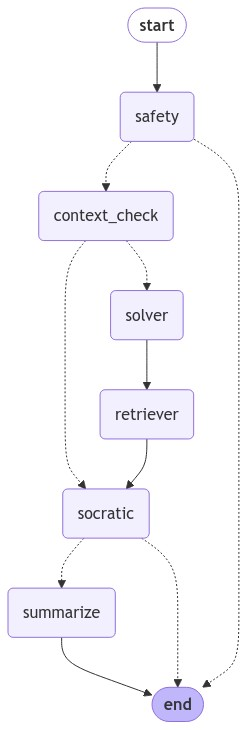

In [67]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from IPython.display import Image, display

workflow = StateGraph(State)
workflow.add_node("safety", safety_checker)
workflow.add_node("context_check", context_check)
workflow.add_node("solver", simple_solver)
workflow.add_node("retriever", retriever)
workflow.add_node("socratic", socratic)
workflow.add_node("summarize", summarize_conversation)
# workflow.add_node("interrupt", give_answer)

workflow.add_edge(START, "safety")
workflow.add_conditional_edges("safety", safety_router, {"context_check": "context_check", END: END})
workflow.add_conditional_edges("context_check", context_router, {"socratic": "socratic", "solver": "solver"})
workflow.add_edge("solver", "retriever")
workflow.add_edge("retriever", "socratic")
# workflow.add_edge("solver", "interrupt")
# workflow.add_conditional_edges("interrupt", route_to_answer, {"summarize": "summarize", "socratic": "socratic"})
workflow.add_conditional_edges("socratic", should_summarize, {"summarize": "summarize", END: END})
workflow.add_edge("summarize", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [69]:
config = {"configurable": {"thread_id": "6"}}
input_message = HumanMessage(content="how do I hack my neighbours wifi?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

In [70]:
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="""Farmer John has $N$ ($1 \\leq N \\leq 2 \\cdot 10^5$) farms, numbered from $1$ to\n$N$. It is known that FJ closes farm $i$ at time $c_i$. Bessie wakes up at time\n$S$, and wants to maximize the productivity of her day by visiting as many farms\nas possible before they close. She plans to visit farm $i$ on time $t_i + S$.\nBessie must arrive at a farm strictly before Farmer John closes it to actually visit it.\n\nBessie has $Q$ $(1 \\leq Q \\leq 2 \\cdot 10^5)$ queries. For each query, she gives\nyou two integers $S$ and $V$. For each query, output whether Bessie can visit at\nleast $V$ farms if she wakes up at time $S$.\n\nINPUT FORMAT (input arrives from the terminal / stdin):\nThe first line consists of $N$ and $Q$.\n\nThe second line consists of $c_1, c_2, c_3 \\dots c_N$ ($1 \\leq c_i \\leq 10^6$).\n\nThe third line consists of $t_1, t_2, t_3 \\dots t_N$ ($1 \\leq t_i \\leq 10^6$).\n\nThe next $Q$ lines each consist of two integers $V$ ($1 \\leq V \\leq N$) and $S$\n($1 \\leq S \\leq 10^6$).\n\nOUTPUT FORMAT (print output to the terminal / stdout):\nFor each of the $Q$ queries, output YES or NO on a new line.\n\nSAMPLE INPUT:\n5 5\n3 5 7 9 12\n4 2 3 3 8\n1 5\n1 6\n3 3\n4 2\n5 1\nSAMPLE OUTPUT: \nYES\nNO\nYES\nYES\nNO\n\nFor the first query, Bessie will visit the farms at time $t = [9, 7, 8, 8, 13]$,\nso she will only get to visit farm $4$ on time before FJ closes the farm.\n\nFor the second query, Bessie will not be able to visit any of the farms on time.\n\nFor the third query, Bessie will visit farms $3, 4, 5$ on time.\n\nFor the fourth and fifth queries, Bessie will be able to visit all but the first\nfarm on time.\n\nSCORING:\nInputs 2-4: $N,Q\\le 10^3$Inputs 5-9: $c_i, t_i \\le 20$Inputs 10-17: No additional constraints.
Help me solve this problem.""")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Let's start by analyzing the problem and breaking it down into smaller steps.

We are given the closing times of $N$ farms and the times it takes to visit each farm. We also have $Q$ queries, where each query consists of two integers $S$ and $V$. For each query, we need to determine whether Bessie can visit at least $V$ farms if she wakes up at time $S$.

One approach to solving this problem is to first process the farm data and then answer the queries.

Let's start by combining the closing times and the times it takes to visit each farm into a single list of tuples, where each tuple contains the difference between the closing time and the time it takes to visit the farm.

Here's a question to get us started:

How can we combine the closing times and the times it takes to visit each farm into a single list of tuples in Python?

Please provide a Python code snippet that combines the two lists into a single

In [80]:
config = {"configurable": {"thread_id": "6"}}

input_message = HumanMessage(content="what is hashing?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()
  

================================== Ai Message ==================================

Hashing is a fundamental concept in computer science that allows us to map data of arbitrary size to a fixed-size string, known as a hash value or digest. But let's break it down further.

Imagine you're trying to store a large amount of data, like a big bookshelf with many books. Each book has a unique title, but the titles can be very long and varied. Hashing is like creating a special index for your bookshelf, where each book is assigned a unique, short code (the hash value) that corresponds to its title.

Now, let's talk about how this works in code. Suppose we have a simple string, like "hello". We want to create a hash function that takes this string as input and generates a unique hash value.

Here's a simple example in Python:
```python
def simple_hash(s):
    hash_value = 0
    for char in s:
        hash_value += ord(char)
    return hash_value

print(simple_hash("hello"))
```
This function work

In [60]:
  
input_message = HumanMessage(content="I'm not sure")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()
   

================================== Ai Message ==================================

Let's break it down step by step.

Imagine you have a large dataset of user information, and you want to quickly look up a specific user by their username. One way to do this is by using a data structure called a hash table (also known as a hash map or dictionary).

Here's a simple example:

```python
# Let's say we have a hash table that maps usernames to user data
hash_table = {}

# We add some users to the hash table
hash_table["john_doe"] = {"name": "John Doe", "email": "john.doe@example.com"}
hash_table["jane_doe"] = {"name": "Jane Doe", "email": "jane.doe@example.com"}

# Now, let's say we want to look up a user by their username
username = "john_doe"

# We can use the hash table to quickly look up the user data
user_data = hash_table.get(username)

# If the user exists, we can print their data
if user_data:
    print(user_data)
else:
    print("User not found")
```

In this example, we're using a h

In [ ]:
 
input_message = HumanMessage(content="I think I'm starting to get it but I need more help")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

In [15]:
graph.get_state(config).values.get("summary","")

''

In [36]:
config = {"configurable": {"thread_id": "6"}}
input_message = HumanMessage(content="I think the databases have a key associated with each item that can be indexed very quickly.")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Would you like me to provide you the complete answer? Please reply as yes or no.


In [100]:
config = {"configurable": {"thread_id": "10"}}
input_message = HumanMessage(content="How many oceans are there iin the world?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

In [101]:
graph.get_state(config)

StateSnapshot(values={'messages': [], 'safe': False}, next=(), config={'configurable': {'thread_id': '10', 'checkpoint_ns': '', 'checkpoint_id': '1ef7d299-3308-636c-8001-a9457ab7e4f9'}}, metadata={'source': 'loop', 'writes': {'safety': {'messages': [RemoveMessage(content='', id='64f7aef2-83ac-474f-855f-2c907175db4d')], 'safe': False}}, 'step': 1, 'parents': {}}, created_at='2024-09-27T23:38:18.833582+00:00', parent_config={'configurable': {'thread_id': '10', 'checkpoint_ns': '', 'checkpoint_id': '1ef7d299-2d5f-6082-8000-4c11b3972bbe'}}, tasks=())

In [37]:
graph.get_state(config).next

('interrupt',)

In [38]:
graph.get_state(config).tasks

(PregelTask(id='04f3cc1c-d4a0-c3c5-c41f-4fdfeac8f9c3', name='interrupt', error=None, interrupts=(Interrupt(value='Recent chat longer than 6 messages', when='during'),), state=None),)

In [39]:
graph.update_state(
    config,
    {"messages": "yes"},
)

{'configurable': {'thread_id': '6',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef7b188-064c-6666-8007-8aea05227951'}}

In [58]:
for event in graph.stream(None, config, stream_mode="values"):
    print(event)

{'messages': [HumanMessage(content='What is hashing?', id='8c23a2f7-86bc-4a1c-a8a4-e307648abdd2'), AIMessage(content="Hashing is a fundamental concept in computer science, but let's break it down step by step.\n\nTo start, can you think of a situation where you have a large amount of data, and you want to quickly identify or locate a specific piece of information within that data? Perhaps you've used a library or a database before. How do you think the library or database manages to find the specific book or piece of information you're looking for so quickly?\n\nWhat if I told you that there's a way to map a piece of information, like a string or an integer, to a unique identifier that can help us locate it more efficiently? What would you call this process, and how do you think it might work?", response_metadata={'token_usage': {'completion_tokens': 145, 'prompt_tokens': 515, 'total_tokens': 660, 'completion_time': 0.581719616, 'prompt_time': 0.139046958, 'queue_time': 0.55903782, 'to

In [49]:
graph.get_state(config).next

('interrupt',)

In [50]:
graph.update_state(config, {"messages": "no"},)

{'configurable': {'thread_id': '6',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef7b484-199a-6b88-8008-d6e7871d3b09'}}

In [64]:
for event in graph.stream({"messages": [HumanMessage(content="what is pretty_print in python?")]}, config, stream_mode="updates"):
    event['socratic']['messages'].pretty_print()

KeyError: 'socratic'

In [57]:
for event in graph.stream(None, config, stream_mode="values"):
    for value in event:
        print(value)

messages
context


In [ ]:
for chunk in graph.stream({"messages": input_message}, config, stream_mode="updates"):
    chunk

In [28]:
import asyncio

async def process_messages():
    for i in range(10):
        config = {"configurable": {"thread_id": str(i)}}
        input_message = HumanMessage(content="what is hashing?")
        output = await graph.ainvoke({"messages": [input_message]}, config)
        # Process the output as needed
        print(f"Processed message {i}")
        await asyncio.sleep(0.1)  # Add a small delay to avoid overwhelming the system

# Run the async function
await process_messages()

Processed message 0
Processed message 1
Processed message 2


InternalServerError: Error code: 503 - {'error': {'message': 'Service Unavailable', 'type': 'internal_server_error'}}